In [1]:
import torch
import torch.backends.cudnn as cudnn
device = torch.cuda.set_device('cuda:1')
import matplotlib.pyplot as plt
from skimage.io import imread 
from skimage.transform import resize
import numpy as np
from utils import *

In [2]:
import archs

In [3]:
model = archs.NestedUNet(1, 3, False)

In [4]:
model = model.cuda()

In [5]:
#Load save model
model.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

In [6]:
model.eval()

NestedUNet(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (up): Upsample(scale_factor=2.0, mode=bilinear)
  (conv0_0): VGGBlock(
    (relu): ReLU(inplace=True)
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv1_0): VGGBlock(
    (relu): ReLU(inplace=True)
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2_0): VGGBlock(
    (relu): ReLU(inplace=True)
    

In [7]:
network_size = (256,256,3)

In [8]:
overlap = 0

In [9]:
image = imread('/data/spacenet/bldg/data/validation/MUL/MUL-PanSharpen_AOI_2_Vegas_img1016.tif')
image = np.array((image[:,:,[4,2,1]]/(image[:,:,[4,2,1]].max()+1e-10)), dtype=np.float32)
image = np.array(image*256, dtype=np.uint8)
image = resize(image, (256, 256, 3))
#img = img.astype('float32') / 255


In [10]:
image_size = list(image.shape[0:2]) #Get image size and push to a list
tile_size = list(network_size[0:2]) #Get tile size as first two dimensions of network_size
        
corners = find_corners(image_size, tile_size, network_size, overlap)

tilesArr = create_tiles(image, corners, network_size)



In [11]:
image = imread('/data/spacenet/bldg/data/validation/MUL/MUL-PanSharpen_AOI_2_Vegas_img1016.tif')
img = np.array((image[:,:,[4,2,1]]/(image[:,:,[4,2,1]].max()+1e-10)), dtype=np.float32)
img = np.array(img*256, dtype=np.uint8)
img = resize(img, (256, 256, 3))


img = img.astype('float32') / 255
img = img.transpose(2, 0, 1)
img = img.reshape(1,3,256,256)
img = torch.from_numpy(img)
img = img.cuda()
print(type(img))

<class 'torch.Tensor'>


In [12]:
output = model(img)

In [13]:
output = output.cpu()

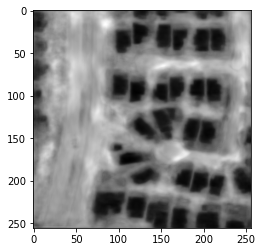

In [14]:
plt.imshow(output.detach().numpy()[0,0,:,:], cmap = 'gray')

In [15]:
torch.cuda.empty_cache()